In [42]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE


Reading Data

In [68]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()

# drop_columns = ['Date', 'RegionName', 'State', '']
merged_data.drop(columns= 'Date', inplace=True)

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on='RegionName', right_on='NAMELSAD')

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

# Get column names with object data types
object_columns = merged_data.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
merged_data = merged_data.drop(object_columns, axis=1)
merged_data = merged_data.drop(columns='geometry', axis=1)

In [69]:
#Making sure that all dtypes are int or floats
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2789072 entries, 0 to 2789071
Data columns (total 19 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   Unnamed: 0                               int64  
 1   Year                                     int64  
 2   Month                                    int64  
 3   Bottom-Tier Average Home Value Estimate  float64
 4   Top-Tier Average Home Value Estimate     float64
 5   Value                                    float64
 6   Anomaly (1901-2000 base period)          float64
 7   1901-2000 Mean                           float64
 8   Initial Fees and Charges (%)             float64
 9   Effective Rate (%)                       float64
 10  Term to Maturity                         int64  
 11  Loan Amount ($thou)                      float64
 12  Purchase Price ($thou)                   float64
 13  Loan-to-Price Ratio (%)                  float64
 14  Share of Total Mar

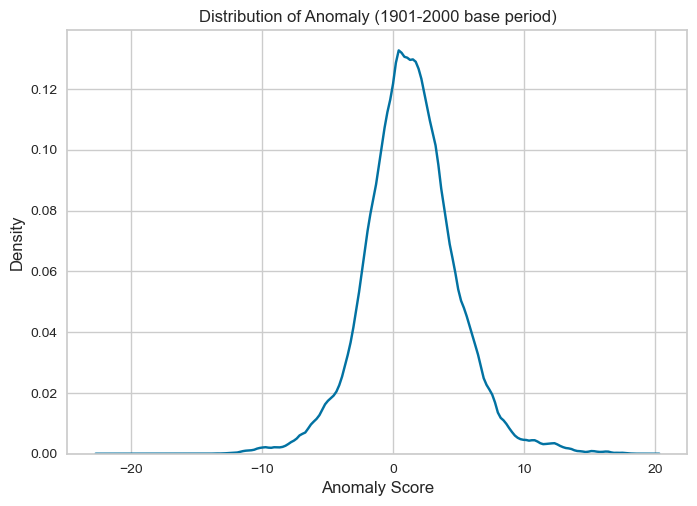

In [70]:
# Looking at the spread of the data 
target_variable = merged_data['Anomaly (1901-2000 base period)']

# Plot the KDE plot
sns.kdeplot(target_variable)
plt.title('Distribution of Anomaly (1901-2000 base period)')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.show()

In [71]:
merged_data['Anomaly (1901-2000 base period)'].describe()

count    2.789072e+06
mean     1.335827e+00
std      3.474857e+00
min     -2.220000e+01
25%     -8.000000e-01
50%      1.200000e+00
75%      3.400000e+00
max      1.980000e+01
Name: Anomaly (1901-2000 base period), dtype: float64

In [72]:
# Define the bins and labels for each class
bins = [-float('inf'), -0.6, 3.4, float('inf')]
labels = [1.0, 2.0, 3.0]  # Corresponding labels for each bin

# Create the multiclass labels using cut function and assign it to a new column
merged_data['multiclass_label'] = pd.cut(merged_data['Anomaly (1901-2000 base period)'], bins=bins, labels=labels)

# Convert the labels to integer type
merged_data['multiclass_label'] = merged_data['multiclass_label'].astype(int)

# Print the first few rows to verify
merged_data.head()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,multiclass_label
0,0,2000,1,122826.545216,400192.738911,52.3,4.5,47.8,0.93,8.01,15,103.0,173.6,64.7,7.0,1.051599e+10,1.785003e+09,34.196398,-118.261862,3
1,1,2000,1,122826.545216,400192.738911,52.3,4.5,47.8,0.81,8.20,30,129.9,166.8,81.1,61.1,1.051599e+10,1.785003e+09,34.196398,-118.261862,3
2,1566,2000,2,122977.776411,400660.415894,50.6,1.1,49.5,0.91,8.18,15,100.5,172.8,63.1,7.2,1.051599e+10,1.785003e+09,34.196398,-118.261862,2
3,1567,2000,2,122977.776411,400660.415894,50.6,1.1,49.5,0.78,8.39,30,127.8,163.7,81.2,58.6,1.051599e+10,1.785003e+09,34.196398,-118.261862,2
4,3136,2000,3,123487.708531,402315.707957,53.8,1.7,52.1,0.87,8.24,15,101.2,176.9,62.7,7.2,1.051599e+10,1.785003e+09,34.196398,-118.261862,2


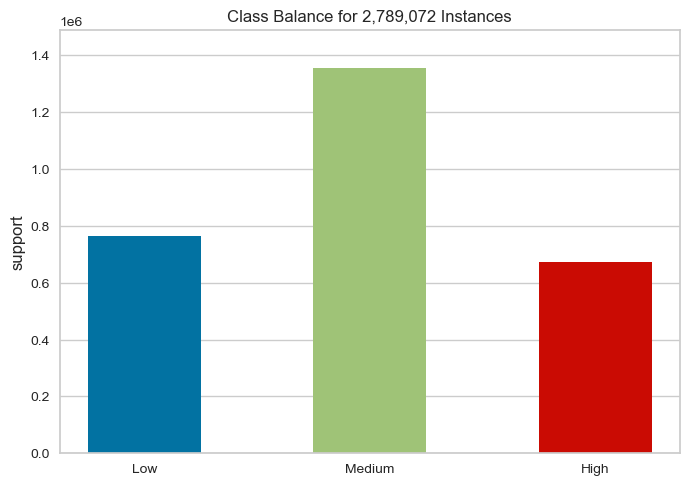

<Axes: title={'center': 'Class Balance for 2,789,072 Instances'}, ylabel='support'>

In [73]:
labels = ["Low", "Medium", "High"]

visualizer = ClassBalance(labels=labels)
visualizer.fit(merged_data['multiclass_label'])

# Show the visualizer
visualizer.show()

In [74]:
#splitting the data 
seed = 7

X = merged_data[merged_data.columns.difference(['multiclass_label'])]
y = merged_data['multiclass_label']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

print(y_test)

652726     2
1599435    2
1310279    3
443777     2
2393260    2
          ..
1477259    2
1541829    2
1160164    3
2395092    2
827588     1
Name: multiclass_label, Length: 697268, dtype: int64


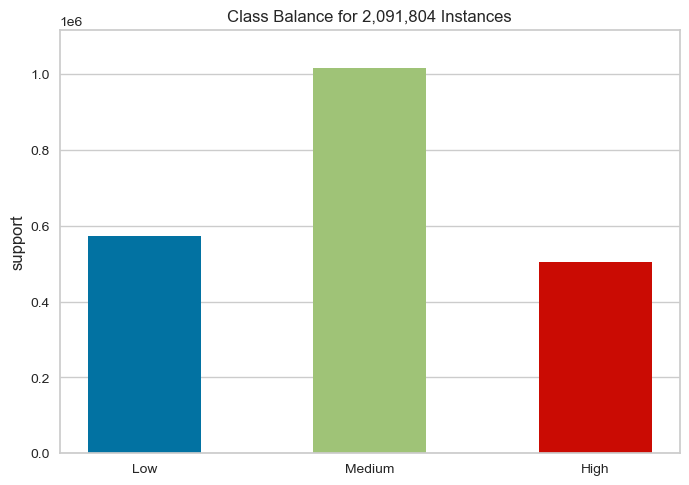

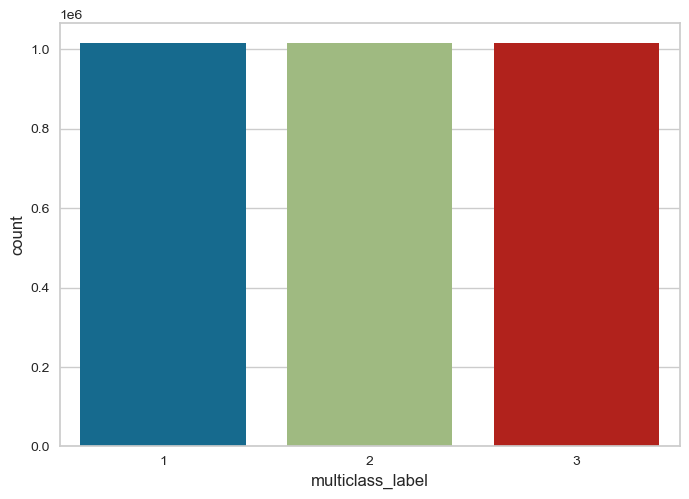

In [75]:
# your code here
labels_temperature = ['Low', 'Medium', 'High']
visualizer = ClassBalance(labels = labels_temperature)
visualizer.fit(y_train)  
visualizer.show()   

#Using a SMOTE Approach to address class imbalance
#SMOTE
sm = SMOTE(random_state=17)

#Resample
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
sns.countplot(x=y_train_smote, tick_label=labels_temperature)
plt.show()